In [1]:
import sys
sys.path.append('../..') 
sys.path.append('..') 
import numpy as np
import cv2 as cv
import os
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from keras import layers
from tensorflow import keras
import gc
import matplotlib.pyplot as plt
from tools.GA.FilterGeneticAlgorithm import FilterGeneticAlgorithm

In [2]:
path = "datasets/Monkeypox Skin Lesion"

items = os.listdir(path)

folder_paths = [path+"/"+item for item in items if os.path.isdir(os.path.join(path, item))]

for path in folder_paths:
    print(path)

datasets/Monkeypox Skin Lesion/Monkey Pox
datasets/Monkeypox Skin Lesion/Others


In [3]:
def get_Data(folder_path,cls):
    X = []
    Y=[]
    for root, directories, files in os.walk(folder_path):
        for filename in files:
            img=cv.imread(os.path.join(root, filename))
            img=cv.cvtColor(img, cv.COLOR_RGB2BGR)
            img=cv.resize(img, (224,224))
            X.append(img)
            Y.append(cls)
    return X,Y

In [4]:
X=[]
Y=[]

for cls,folder_path in enumerate(folder_paths):
    x,y=get_Data(folder_path,cls)
    X=X+x
    Y=Y+y

In [5]:
X_train, X_test, Y_train, Y_test=train_test_split(X, Y, test_size=0.3, random_state=42)

In [6]:
X_train=np.array(X_train)
Y_train=np.array(Y_train)
X_test=np.array(X_test)
Y_test=np.array(Y_test)

print(f"X_train:{X_train.shape} Y_train:{Y_train.shape} X_test:{X_test.shape} Y_test:{Y_test.shape}")

X_train:(159, 224, 224, 3) Y_train:(159,) X_test:(69, 224, 224, 3) Y_test:(69,)


In [7]:
model = keras.models.Sequential([
    layers.BatchNormalization(input_shape=(224, 224, 3)),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Flatten(),
    layers.Dense(len(folder_path), activation='softmax')
])

In [8]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)
splits = list(kf.split(X_test))

In [16]:
evaluations=0

for train_index, test_index in splits.copy():
    m= keras.models.clone_model(model)

    m.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

    train_index, test_index = train_index.tolist(), test_index.tolist()
    x_train, x_test, y_train, y_test = np.array(X_test)[train_index], np.array(X_test)[test_index], np.array(Y_test)[train_index], np.array(Y_test)[test_index]

    m.fit(x_train, y_train, epochs=1, batch_size=32)
    evaluations+=m.evaluate(x_test,y_test)[1]

    gc.collect()
print(evaluations/10)

1/1 [==============================] - 0s 162ms/step - loss: 28.5322 - accuracy: 0.6667
0.6095238298177719


In [10]:
filterGeneticAlgorithm=FilterGeneticAlgorithm(X_train=X_train,Y_train=Y_train, model=model, loss=keras.losses.SparseCategoricalCrossentropy())

In [11]:
best_filter= filterGeneticAlgorithm.run(generation_limit=3, population_size=24)

--------------------------------------------------------------------------------
1/1 [==============================] - 0s 167ms/step - loss: 15.3675 - accuracy: 0.6000
filter [0, 179, 0, 255, 0, 255, 0, 0, 0, 0, 5, 1, 1, 100, 200, 0] fit: 0.5350000023841858
--------------------------------------------------------------------------------
1/1 [==============================] - 0s 162ms/step - loss: 0.8158 - accuracy: 0.4000
filter [48, 109, 56, 155, 35, 240, 0, 199, 39, 124, 1, 4, 2, 50, 171, 2] fit: 0.5087500005960465
--------------------------------------------------------------------------------
1/1 [==============================] - 0s 161ms/step - loss: 3.4926 - accuracy: 0.6667
filter [38, 166, 27, 249, 50, 164, 74, 18, 40, 37, 0, 3, 1, 127, 330, 0] fit: 0.5916666686534882
--------------------------------------------------------------------------------
1/1 [==============================] - 0s 163ms/step - loss: 0.9191 - accuracy: 0.6000
filter [30, 150, 80, 230, 65, 171, 134, 52,

In [12]:
print(f"\nbest filter :{best_filter.filter} fit: {best_filter.fit}")


best filter :[38, 166, 27, 249, 50, 164, 74, 18, 40, 37, 0, 3, 1, 127, 330, 0] fit: 0.5916666686534882


In [13]:
filtered_X_train=np.array(filterGeneticAlgorithm.get_newData(X_train,filter=best_filter.filter))
filtered_X_test=np.array(filterGeneticAlgorithm.get_newData(X_test,filter=best_filter.filter))


print(f"X_train:{filtered_X_train.shape} Y_train:{Y_train.shape} X_test:{filtered_X_test.shape} Y_test:{Y_test.shape}")

X_train:(159, 224, 224, 3) Y_train:(159,) X_test:(69, 224, 224, 3) Y_test:(69,)


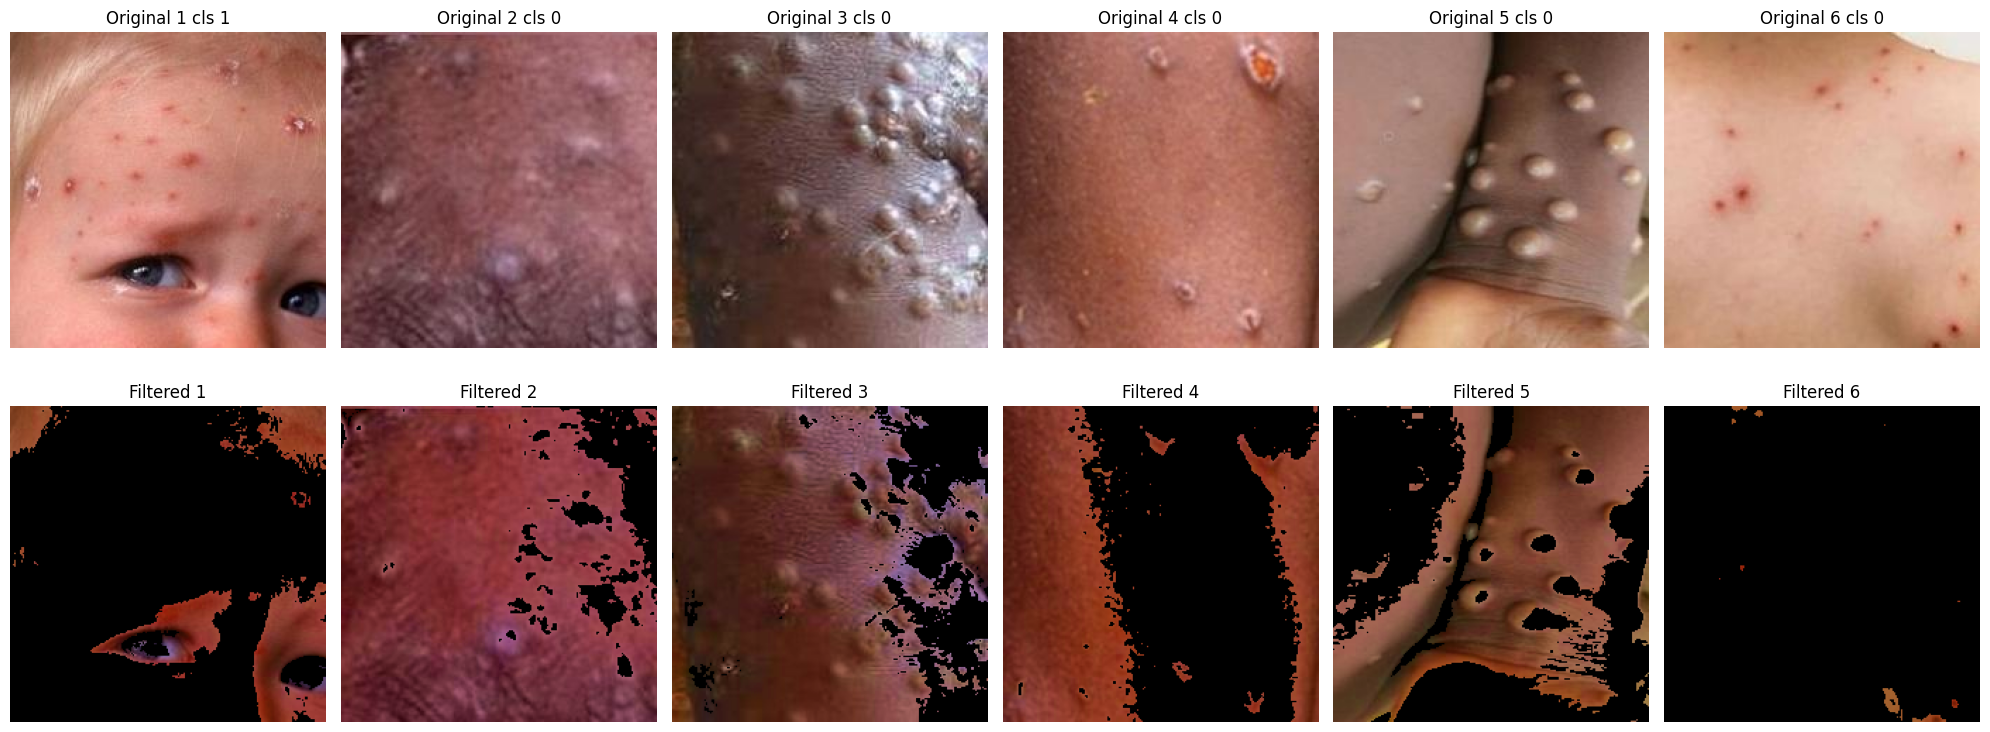

In [28]:
indices = np.random.randint(0, len(X_test), size=6)

fig, axes = plt.subplots(2, 6, figsize=(20, 8))

for i, ax_col in enumerate(axes.T):
    original_index = indices[i]
    
    ax_col[0].imshow(X_test[original_index])
    ax_col[0].set_title(f'Original {i+1} cls {Y_test[original_index]}')
    ax_col[0].axis('off')
    
    ax_col[1].imshow(filtered_X_test[original_index])
    ax_col[1].set_title(f'Filtered {i+1}')
    ax_col[1].axis('off')

plt.tight_layout()
plt.show()


In [17]:
evaluations=0

for train_index, test_index in splits.copy():
    m= keras.models.clone_model(model)

    m.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

    train_index, test_index = train_index.tolist(), test_index.tolist()
    x_train, x_test, y_train, y_test = np.array(filtered_X_test)[train_index], np.array(filtered_X_test)[test_index], np.array(Y_test)[train_index], np.array(Y_test)[test_index]

    m.fit(x_train, y_train, epochs=1, batch_size=32)
    evaluations+=m.evaluate(x_test,y_test)[1]

    gc.collect()
print(evaluations/10)

1/1 [==============================] - 0s 160ms/step - loss: 0.7110 - accuracy: 0.6667
0.5380952581763268
